In [199]:
# %pip install torchsummary

In [200]:
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [220]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [202]:
#Importing the reqired libraries
import numpy as np 
import pandas as pd 
import os


for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))





<>:12: SyntaxWarning: invalid escape sequence '\i'
<>:12: SyntaxWarning: invalid escape sequence '\i'
C:\Users\omsin\AppData\Local\Temp\ipykernel_15548\422690034.py:12: SyntaxWarning: invalid escape sequence '\i'
  cifar10_dir = 'kaggle\input\deep-learning-mini-project-spring-24-nyu\cifar-10-python\cifar-10-batches-py'


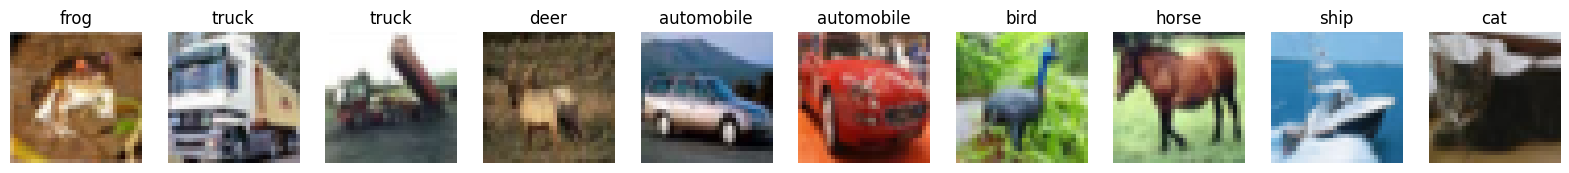

In [203]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = 'kaggle\input\deep-learning-mini-project-spring-24-nyu\cifar-10-python\cifar-10-batches-py'

# Load the label names
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = meta_data_dict[b'label_names']

# Load one batch for demonstration (e.g., data_batch_1)
batch_1_dict = load_cifar_batch(os.path.join(cifar10_dir, 'data_batch_1'))
train_images = batch_1_dict[b'data']
train_labels = batch_1_dict[b'labels']

# Reshape the images
train_images = train_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

# Display the first 10 images and labels
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_images[i])
    plt.title(label_names[train_labels[i]].decode('utf-8'))  # Decoding from bytes to string
    plt.axis('off')
plt.show()


In [204]:
# Read the test file, note that it has no labels and needs to be used with your model inference to predict outputs.

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# Load the batch
cifar10_batch = load_cifar_batch('C:/Users/omsin/Downloads/Mini_Project-DeepLearning/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar_test_nolabels.pkl')

# Extract images
images = cifar10_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) 

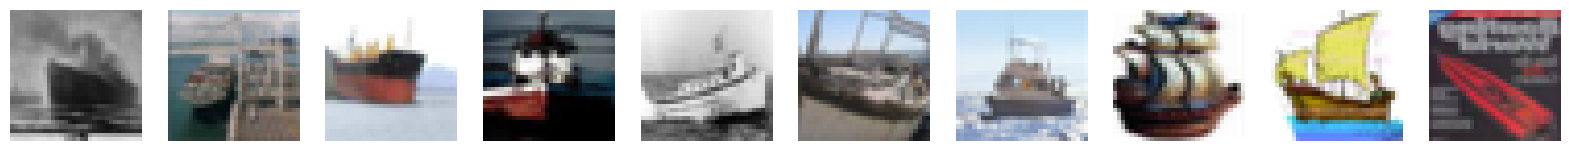

In [205]:
# Extract images and convert back to image format
images = cifar10_batch[b'data']
# Reshape to (number of images, width, height, channels)
images = images.reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)

# Display the first 10 images
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [221]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 42  # Reduced from 48 to 42

        self.conv1 = nn.Conv2d(3, 42, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(42)
        self.layer1 = self._make_layer(block, 42, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 84, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 168, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 336, num_blocks[3], stride=2)
        self.linear = nn.Linear(336 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10)

# Instantiate the model and calculate parameters
model = ResNet18().to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", num_params)


Number of parameters:  4815940


In [207]:
from torchsummary import summary

# Use torchsummary to print the summary of the model. Specify the input size (channels, height, width)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 42, 32, 32]           1,134
       BatchNorm2d-2           [-1, 42, 32, 32]              84
              ReLU-3           [-1, 42, 32, 32]               0
            Conv2d-4           [-1, 42, 32, 32]          15,876
       BatchNorm2d-5           [-1, 42, 32, 32]              84
              ReLU-6           [-1, 42, 32, 32]               0
           Dropout-7           [-1, 42, 32, 32]               0
            Conv2d-8           [-1, 42, 32, 32]          15,876
       BatchNorm2d-9           [-1, 42, 32, 32]              84
             ReLU-10           [-1, 42, 32, 32]               0
       BasicBlock-11           [-1, 42, 32, 32]               0
           Conv2d-12           [-1, 42, 32, 32]          15,876
      BatchNorm2d-13           [-1, 42, 32, 32]              84
             ReLU-14           [-1, 42,

In [223]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os
import pickle

# Load the CIFAR-10 batch data
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load and transform the CIFAR-10 dataset
def load_all_batches(cifar10_dir):
    train_images = []
    train_labels = []

    # Load all five batches
    for i in range(1, 6):
        batch_file = os.path.join(cifar10_dir, f'data_batch_{i}')
        batch_data = load_cifar_batch(batch_file)
        train_images.append(batch_data[b'data'])
        train_labels.extend(batch_data[b'labels'])

    train_images = np.vstack(train_images).reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)
    train_labels = np.array(train_labels)
    return train_images, train_labels

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = 'kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py'
train_images, train_labels = load_all_batches(cifar10_dir)

# Transformation pipeline
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Prepare dataset
train_tensors = torch.stack([transform_train(image) for image in train_images])
train_labels = torch.tensor(train_labels, dtype=torch.long)  # Explicitly specifying the data type
train_dataset = TensorDataset(train_tensors, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model, Loss, and Optimizer
# Assuming ResNet18 is defined in the models module
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)



import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os
import pickle

def train_model_with_checkpoint(train_loader, model, criterion, optimizer, scheduler, num_epochs=20, save_path='./model_checkpoints'):
    best_accuracy = 0  # to store the best validation accuracy
    loss_history = []
    accuracy_history = []

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        avg_loss = total_loss / len(train_loader)
        accuracy = 100 * correct / total
        
        loss_history.append(avg_loss)
        accuracy_history.append(accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
        
        # Checkpointing logic
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            print(f"New best accuracy: {best_accuracy:.2f}%. Saving model...")
            torch.save(model.state_dict(), os.path.join(save_path, 'best_model.pth'))
        
        # Save model at fixed intervals (e.g., every 10 epochs)
        if epoch % 10 == 0:
            print("Saving checkpoint...")
            torch.save(model.state_dict(), os.path.join(save_path, f'model_epoch_{epoch}.pth'))
        
        scheduler.step()

    return loss_history, accuracy_history

# Directory to save model checkpoints
checkpoint_dir = './model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Train the model and collect metrics
loss_history, accuracy_history = train_model_with_checkpoint(train_loader, model, criterion, optimizer, scheduler, num_epochs=30, save_path=checkpoint_dir)






Epoch [1/30], Loss: 1.9415, Accuracy: 29.20%
New best accuracy: 29.20%. Saving model...
Saving checkpoint...
Epoch [2/30], Loss: 1.4542, Accuracy: 46.54%
New best accuracy: 46.54%. Saving model...
Epoch [3/30], Loss: 1.1390, Accuracy: 59.26%
New best accuracy: 59.26%. Saving model...
Epoch [4/30], Loss: 0.9393, Accuracy: 66.84%
New best accuracy: 66.84%. Saving model...
Epoch [5/30], Loss: 0.8051, Accuracy: 71.94%
New best accuracy: 71.94%. Saving model...
Epoch [6/30], Loss: 0.7131, Accuracy: 75.27%
New best accuracy: 75.27%. Saving model...
Epoch [7/30], Loss: 0.6649, Accuracy: 77.03%
New best accuracy: 77.03%. Saving model...
Epoch [8/30], Loss: 0.6237, Accuracy: 78.45%
New best accuracy: 78.45%. Saving model...
Epoch [9/30], Loss: 0.5942, Accuracy: 79.47%
New best accuracy: 79.47%. Saving model...
Epoch [10/30], Loss: 0.5619, Accuracy: 80.64%
New best accuracy: 80.64%. Saving model...
Epoch [11/30], Loss: 0.5467, Accuracy: 81.23%
New best accuracy: 81.23%. Saving model...
Saving ch

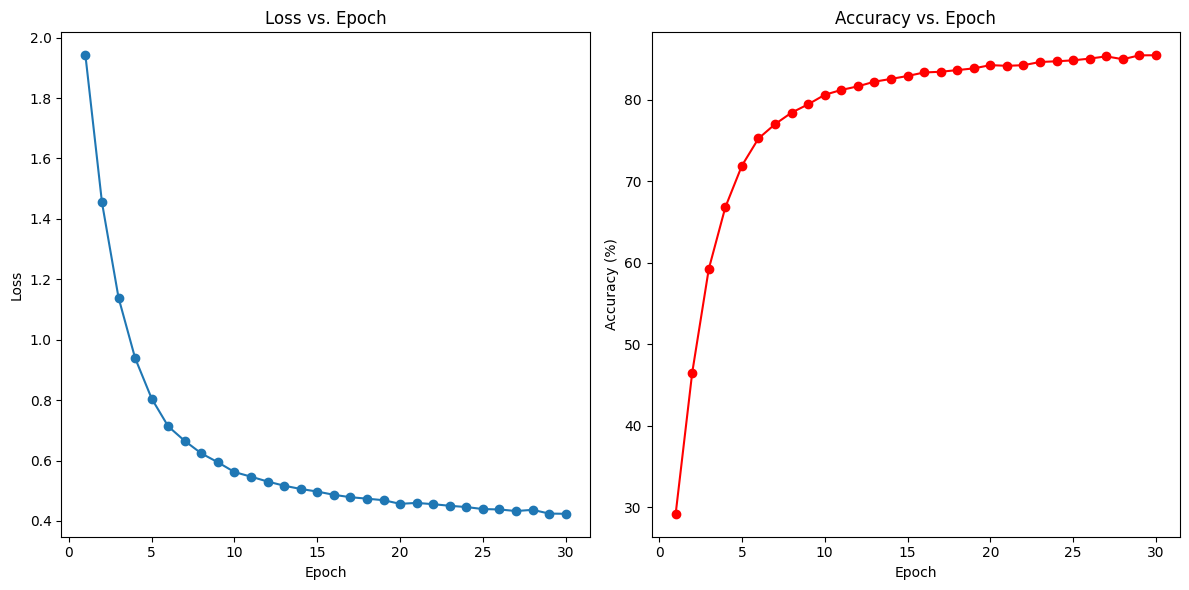

In [224]:
# Training function
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, 31), loss_history, marker='o')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, 31), accuracy_history, marker='o', color='r')
plt.title('Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

In [225]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import numpy as np

# Assuming all necessary imports and model definition have been handled as previously discussed

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Corrected device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to evaluate the model accuracy
def evaluate_accuracy(data_loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Load and prepare the test data
__path__ = 'C:/Users/omsin/Downloads/Mini_Project-DeepLearning/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/test_batch'
test_data = load_cifar_batch(__path__)
test_images = test_data[b'data'].reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)
test_labels = np.array(test_data[b'labels'])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
test_tensors = torch.stack([transform_test(Image.fromarray(image)) for image in test_images])
test_labels_tensor = torch.tensor(test_labels)
test_dataset = TensorDataset(test_tensors, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Evaluate the model
test_accuracy = evaluate_accuracy(test_loader, model)
print("Test Accuracy:", test_accuracy)


Test Accuracy: 79.33


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


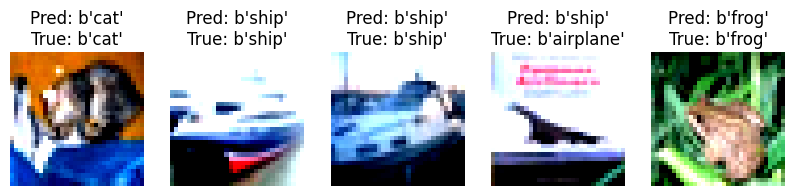

In [226]:
import matplotlib.pyplot as plt
import torch

def visualize_test_predictions(model, data_loader, num_images=5):
    model.eval()  # Set the model to evaluation mode
    images, labels = next(iter(data_loader))  # Get one batch of test images and labels
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)  # Get model outputs for the batch
    _, predictions = torch.max(outputs, 1)  # Determine predicted class indices

    plt.figure(figsize=(10, 3))  # Set the figure size for the plots
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)  # Create a subplot for each image
        img = images[i].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5  # Unnormalize and prepare for display
        plt.imshow(img)  # Display the image
        plt.title(f'Pred: {label_names[predictions[i]]}\nTrue: {label_names[labels[i]]}')  # Show predicted and true labels
        plt.axis('off')  # Hide axes to improve visual clarity
    plt.show()  # Display the plot

# Example usage with the model and test_loader
visualize_test_predictions(model, test_loader)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

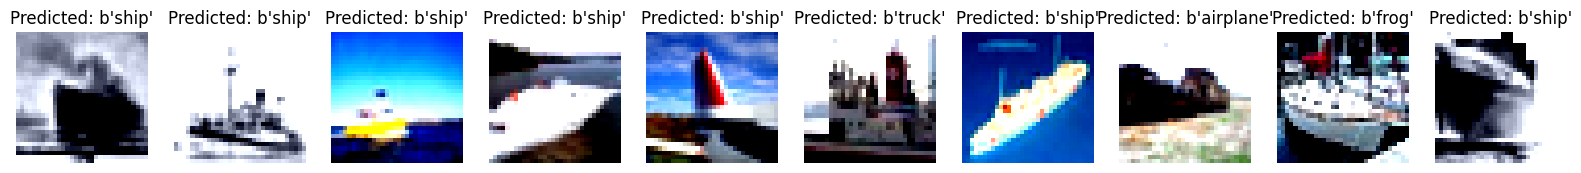

In [227]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pickle
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image

# Function to load the CIFAR data
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch



transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load test data
cifar10_batch = load_cifar_batch('C:/Users/omsin/Downloads/Mini_Project-DeepLearning/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar_test_nolabels.pkl')
images = cifar10_batch[b'data'].reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)
ids = cifar10_batch[b'ids']

# Apply transformation and create DataLoader
test_tensors = torch.stack([transform_test(Image.fromarray(image)) for image in images])
test_dataset = TensorDataset(test_tensors, torch.zeros(len(test_tensors)))  # Dummy labels
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
predictions=[]

# Function to predict and visualize
def predict_and_visualize(model, data_loader, num_images=10):
    model.eval()
    images, _ = next(iter(data_loader))
    images = images.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    predictions.extend(predicted.cpu().numpy())

    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        plt.subplot(1, 10, i + 1)
        plt.imshow(images[-i].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
        plt.title(f'Predicted: {np.array(label_names[predicted[-i]])}')  # Adjust label_names as per your setup
        plt.axis('off')
    plt.show()
    


# Assuming model is already loaded and to device
predict_and_visualize(model, test_loader)



In [228]:
import csv
# Function to predict for all images
def predict_all(model, data_loader):
    model.eval()
    all_predictions = []
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
    return all_predictions

# Call the function to predict all labels
all_predictions = predict_all(model, test_loader)

# Export predictions to a CSV file
with open('full_predictions.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['id', 'label'])
    for id, prediction in zip(ids, all_predictions):
        writer.writerow([id, label_names[prediction]])

print("Full predictions have been saved to 'full_predictions.csv'.")
# Create a mapping dictionary for label names to numbers
label_mapping = {
    b'airplane': 0,
    b'automobile': 1,
    b'bird': 2,
    b'cat': 3,
    b'deer': 4,
    b'dog': 5,
    b'frog': 6,
    b'horse': 7,
    b'ship': 8,
    b'truck': 9
}

def convert_label_to_number(label):
    # Remove the leading 'b' and decode the label to a string
    label_str = label[2:-1].decode('utf-8')
    return label_mapping[label_str.encode()]


# Load the CSV file with labels as strings
with open('full_predictions.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip header
    data = [(int(row[0]), convert_label_to_number(row[1].encode())) for row in reader]

# Save the converted data to a new CSV file
with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ID', 'Labels'])
    for row in data:
        writer.writerow(row)

print("Labels converted and saved to 'submission.csv'.")


Full predictions have been saved to 'full_predictions.csv'.
Labels converted and saved to 'submission.csv'.
